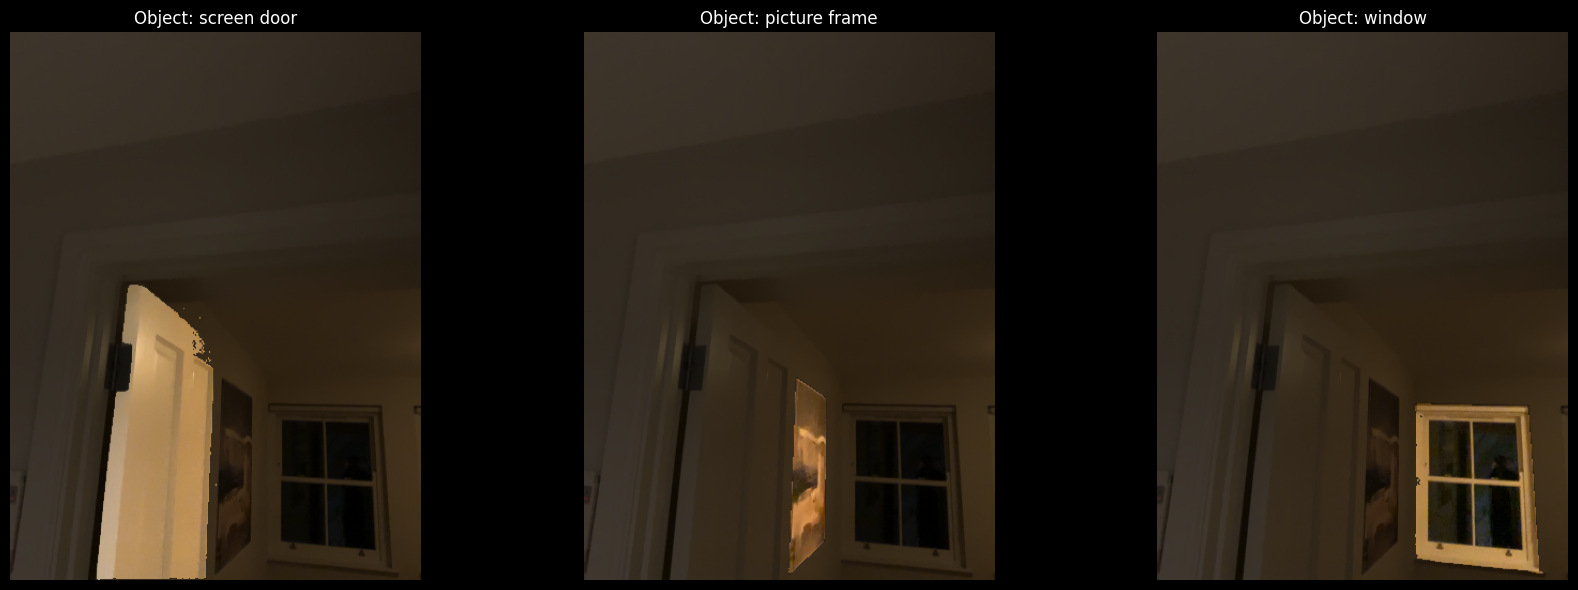

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pycocotools import mask as mask_utils


def rle_2_mask(rle):
    """支持COCO压缩和未压缩RLE格式的解码"""
    if isinstance(rle['counts'], str):  # COCO压缩格式
        rle_obj = {
            'size': rle['size'],
            'counts': rle['counts'].encode('utf-8')
        }
        decoded = mask_utils.decode(rle_obj)
        return decoded.astype(bool)
    else:  # 非压缩格式
        h, w = rle['size']
        counts = list(map(int, rle['counts']))
        mask = np.zeros(h * w, dtype=bool)
        idx = 0
        parity = False
        for count in counts:
            mask[idx:idx+count] = parity
            idx += count
            parity ^= True
        return mask.reshape((w, h)).T


# 读取 JSON 文件
json_path = "/home_sfs/zhouenshen/dataset/3D/cubifyanything/filter_step_20/42444499/2458914221666/wide/detections_with_bbox_label_qwen_spital_caption_mask_pcd.json"
with open(json_path, 'r') as f:
    data = json.load(f)

# 加载图像
image_path = f"{data['image_path'].split('.png')[0]}_resized.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 设置子图
n = len(data["objects"])
plt.figure(figsize=(6 * n, 6))

for idx, obj in enumerate(data["objects"]):
    mask = rle_2_mask(obj["rle"])
    masked_img = image.copy()
    masked_img[~mask] = masked_img[~mask] * 0.3  # 淡化背景

    plt.subplot(1, n, idx + 1)
    plt.imshow(masked_img)
    plt.title(f"Object: {obj['class_name']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Depth shape: (256, 192), dtype: uint16
Depth min: 494, max: 2212


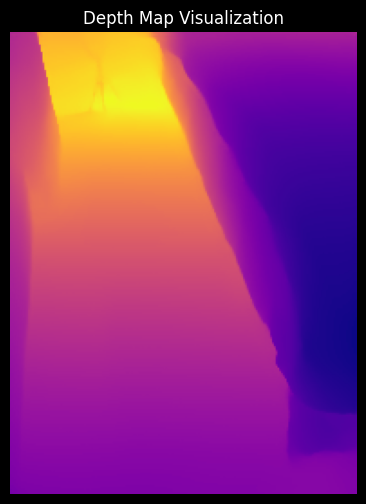

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_depth_map(depth_path, save_path=None):
    """
    可视化深度图（uint16）为伪彩色图。

    Args:
        depth_path (str): 深度图路径（如 .png）
        save_path (str, optional): 如果指定路径，则保存为图片
    """
    # 读取原始深度图（通常为16位）
    depth_raw = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

    if depth_raw is None:
        raise FileNotFoundError(f"无法读取深度图: {depth_path}")

    # 显示深度图基本信息
    print(f"Depth shape: {depth_raw.shape}, dtype: {depth_raw.dtype}")
    print(f"Depth min: {np.min(depth_raw)}, max: {np.max(depth_raw)}")

    # 转为 float32，并归一化到 0-1
    depth_normalized = cv2.normalize(depth_raw.astype(np.float32), None, 0, 1.0, cv2.NORM_MINMAX)

    # 可视化：使用 matplotlib 的伪彩色
    plt.figure(figsize=(8, 6))
    plt.title("Depth Map Visualization")
    plt.imshow(depth_normalized, cmap='plasma')
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"保存可视化图像到: {save_path}")

    plt.show()

# 示例用法
if __name__ == "__main__":
    depth_path = "/home_sfs/zhouenshen/dataset/3D/cubifyanything/filter_step_20/42444503/2536415719291/wide/depth.png"  # 替换为你的路径
    visualize_depth_map(depth_path)

[INFO] shape: (512, 384), dtype: uint16
[INFO] min: 0, max: 1546
[INFO] 可视化图像已保存到: depth_vis.png


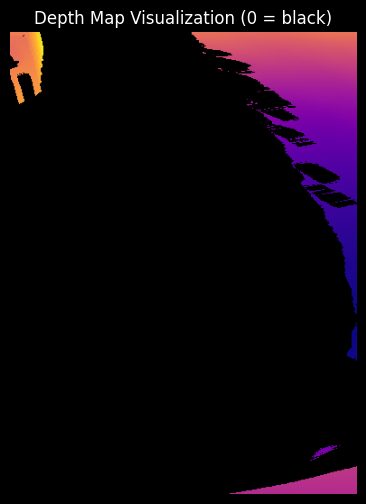

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_depth_with_zero_mask(depth_path, save_path=None, cmap='plasma'):
    """
    可视化深度图，将全为0的像素变为黑色，其余使用伪彩色。

    Args:
        depth_path (str): 深度图路径（一般是 16 位 PNG）
        save_path (str, optional): 如果提供，将保存为图片
        cmap (str): 使用的伪彩色映射：plasma, viridis, inferno, etc.
    """
    # 读取深度图（通常是 uint16）
    depth_raw = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

    if depth_raw is None:
        raise FileNotFoundError(f"无法读取深度图: {depth_path}")

    print(f"[INFO] shape: {depth_raw.shape}, dtype: {depth_raw.dtype}")
    print(f"[INFO] min: {np.min(depth_raw)}, max: {np.max(depth_raw)}")

    # 创建 mask，标记为0的像素
    mask_zero = (depth_raw == 0)

    # 将非0区域归一化到 0-1 用于伪彩色映射
    depth_float = depth_raw.astype(np.float32)
    depth_nonzero = depth_float.copy()
    depth_nonzero[mask_zero] = np.nan  # 忽略0值

    # 归一化（自动忽略 nan）
    vmin = np.nanmin(depth_nonzero)
    vmax = np.nanmax(depth_nonzero)
    norm_depth = (depth_nonzero - vmin) / (vmax - vmin)

    # 使用 matplotlib colormap 转换为 RGB
    colormap = plt.get_cmap(cmap)
    colored = colormap(norm_depth)[:, :, :3]  # 去除 alpha 通道
    colored[np.isnan(norm_depth)] = [0, 0, 0]  # 把0深度的像素变黑

    # 显示
    plt.figure(figsize=(8, 6))
    plt.title("Depth Map Visualization (0 = black)")
    plt.imshow(colored)
    plt.axis('off')

    if save_path:
        plt.imsave(save_path, colored)
        print(f"[INFO] 可视化图像已保存到: {save_path}")

    plt.show()

# 示例用法
if __name__ == "__main__":
    depth_path = "/home_sfs/zhouenshen/dataset/3D/cubifyanything/filter_step_20/42444503/2536415719291/gt/depth.png"   # 替换为你的深度图路径
    visualize_depth_with_zero_mask(depth_path)